# 01. Vector Field Inference with Time-Series Data

This notebook will introduce the usage of fitting velocity model with time-series data.

In [47]:
import scanpy as sc
import pygot 
import torch
import numpy as np
import pandas as pd
import scvelo as scv
from tqdm import tqdm
import matplotlib.pyplot as plt
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

## Gastrulation

The dataset contains single cell RNA expression of mouse gastrulation atlas from [Saja et al., 2019](https://www.nature.com/articles/s41586-019-0933-9). The processed adata file can be download with https://figshare.com/ndownloader/files/54193940

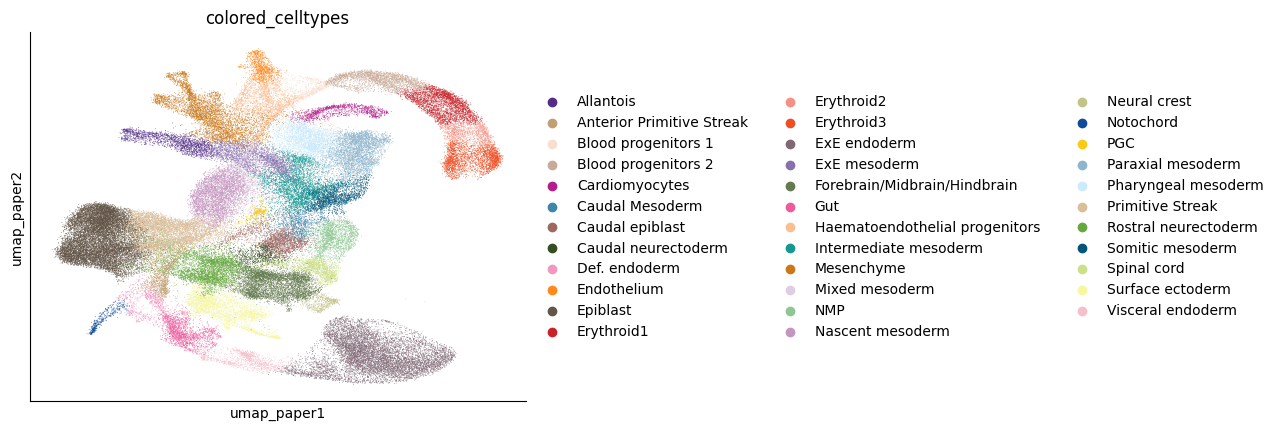

In [29]:
adata = sc.read('../../pygot_data/tutorial_data/GTL.h5ad')
cell_type_key = "colored_celltypes"
sc.pl.embedding(adata, basis="umap_paper", color=cell_type_key)

# Translate the temporal annotation into numeric format
adata.obs['stage_numeric'] = adata.obs['stage'].apply(lambda x: float(x[1:]))
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(np.float32)

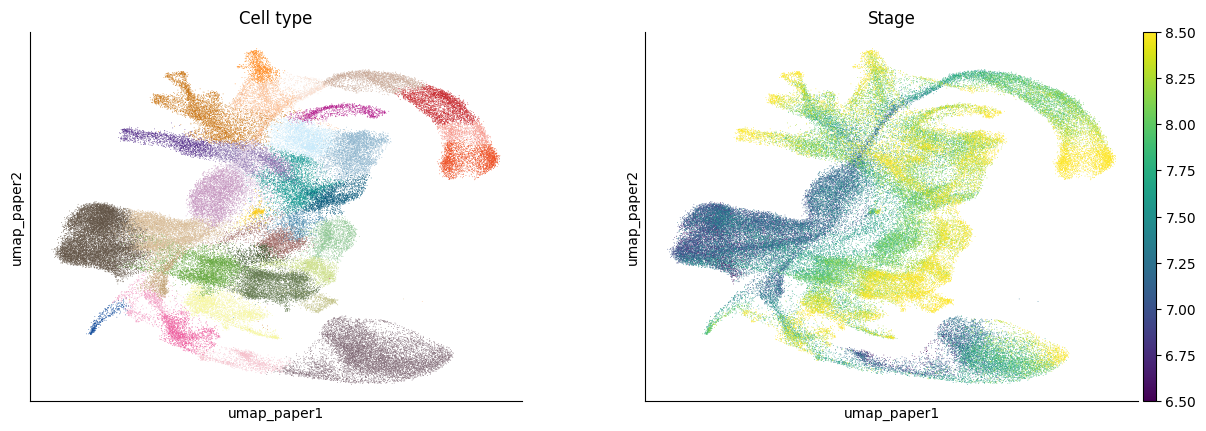

In [31]:
fig = sc.pl.embedding(adata, basis='umap_paper', 
                      color=[cell_type_key, "stage_numeric"], ncols=2, cmap='viridis', legend_loc='down', title=["Cell type", "Stage"], return_fig=True)

In [37]:
#Specify the temporal annotation, latent space
time_key = 'stage_numeric'
embedding_key = 'X_pca'
velocity_key = 'velocity_pca'



In [38]:
#Extract only highly variable genes
adata = adata[:,adata.var['highly_variable']]

In [ ]:
#path to store shortest path distance and index file
model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key=embedding_key, 
        device=device,)

loading saved shortest path profile


loss :3074.5431  best :3022.2213: 100%|███████████████████████████████████████████| 2000/2000 [03:12<00:00, 10.39it/s]


## Velocity inference

In [39]:
# latent velocity inference
adata.obsm[velocity_key] = pygot.tl.traj.latent_velocity(adata, model, time_key=time_key)
# transform latent velocity into gene velocity by PCA components
adata.layers['velocity'] = pygot.tl.traj.latent2gene_velocity(adata, embedding_key=embedding_key, velocity_key=velocity_key,
                                                             A=adata.varm['PCs'].T, dr_mode='linear',)

In [42]:
adata

AnnData object with n_obs × n_vars = 98192 × 2500
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'colored_celltypes', 'stage_numeric'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'colored_celltypes_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper', 'velocity_pca'
    varm: 'PCs'
    layers: 'velocity'
    obsp: 'connectivities', 'distances'

In [43]:
# Combine latent velocity inference and transform into one function 
# gene velocity inference
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model, time_key=time_key, embedding_key=embedding_key, A=adata.varm['PCs'].T, dr_mode='linear')


Note: For nonlinear transform, see Note xxx

## Visualization of low-dimensional (e.g. UMAP) vector field

In [45]:
#compute velocity graph on the base of kNN graph
sc.pp.neighbors(adata, use_rep='X_pca')
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space


computing velocity embedding
    finished (0:00:28) --> added
    'velocity_umap_paper', embedded velocity vectors (adata.obsm)


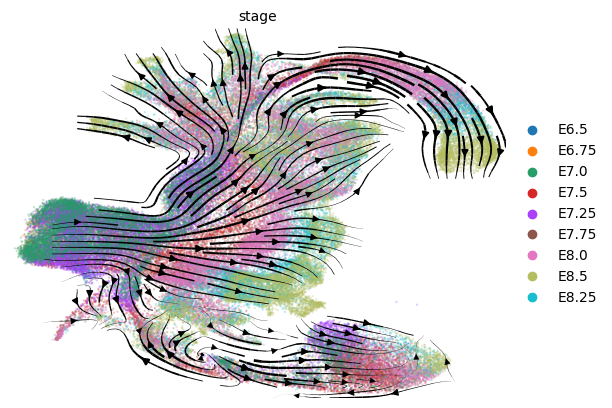

In [48]:
scv.pl.velocity_embedding_stream(adata, color='stage', basis='umap_paper', legend_loc='right')

## Visualization of generated trajectories

In [49]:
# learning a mapping from pca space to umap space
adata.obsm['X_pumap'], map_model = pygot.pp.learn_embed2vis_map(adata, embedding_key, vis_key='X_umap_paper')

Epoch [30/100], Train Loss: 0.2307, Val Loss: 0.3931:  29%|███████▌                  | 29/100 [00:47<01:55,  1.63s/it]

Early stopping triggered
Test Loss: 0.2584


In [73]:
idx = adata[adata.obs[time_key] == 7.0].obs.sample(n=80).index

(100, 80, 50) interpolated number, cell number, dimension


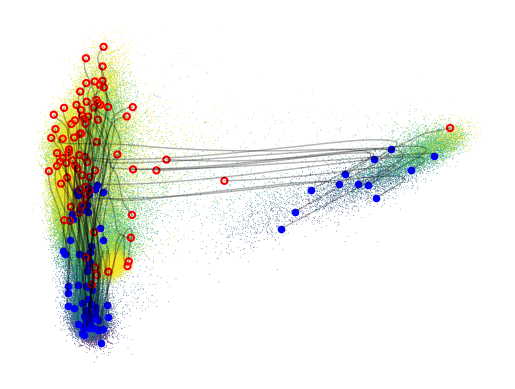

In [78]:
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
# generate trajectories for sampled cells from E7.0 to E8.5 in PCA space
traj = pygot.tl.traj.simulate_trajectory(adata[idx], model, embedding_key, start=7.0, end=8.5)
print(traj.shape, 'interpolated number, cell number, dimension')
# Visualize of the first 2 components
pygot.pl.plot_trajectory(adata, traj[:,:, :2],  basis='pca', ax = ax, embedding_kw={'color':time_key, 'legend_loc':None,})

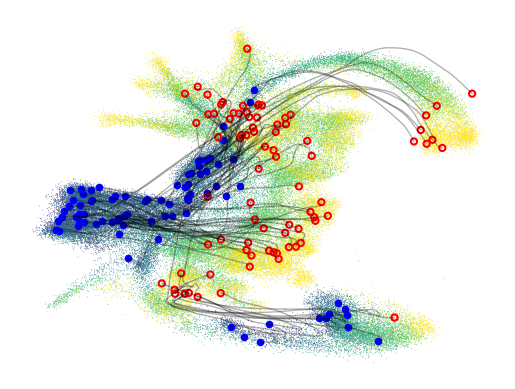

In [79]:
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
# transform the trajectories into umap space
lowd_traj = map_model.transform(traj)
pygot.pl.plot_trajectory(adata, lowd_traj,  basis='pumap', ax = ax, embedding_kw={'color':time_key, 'legend_loc':None,})


In [81]:
torch.save(model, '../../pygot_data/tutorial_data/GTL_model.pkl')